In [2]:
%matplotlib inline

In [3]:
pip install moabb

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install braindecode

In [5]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [6]:
from braindecode.util import set_random_seeds, np_to_var, var_to_np
import matplotlib.pyplot as plt
from moabb.datasets import BNCI2014001, Cho2017, PhysionetMI
from moabb.paradigms import MotorImagery
import numpy as np
from numpy.random import RandomState
import pickle
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

import mne

from util.Motor_Net9 import DpEEG_net
from util.utilfunc import get_balanced_batches
from util.preproc import plot_confusion_matrix

cuda = torch.cuda.is_available()
print('gpu: ', cuda)
device = 'cuda' if cuda else 'cpu'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
rng = RandomState(seed)

gpu:  True


In [7]:
# mne.set_config('MNE_DATA', 'D:\EEG_Motor_Imagery\Dataset')
# mne.set_config('MNE_DATASETS_BNCI_PATH', 'D:\EEG_Motor_Imagery\Dataset')
# mne.set_config('MNE_DATASETS_EEGBCI_PATH', 'D:\EEG_Motor_Imagery\Dataset')
# mne.set_config('MNE_DATASETS_GIGADB_PATH', 'D:\EEG_Motor_Imagery\Dataset')
# print(mne.get_config()) # C:\Users\User\mne-data\

{'MNE_DATA': 'D:\\EEG_Motor_Imagery\\Dataset', 'MNE_DATASETS_BNCI_PATH': 'D:\\EEG_Motor_Imagery\\Dataset', 'MNE_DATASETS_EEGBCI_PATH': 'D:\\EEG_Motor_Imagery\\Dataset', 'MNE_DATASETS_GIGADB_PATH': 'D:\\EEG_Motor_Imagery\\Dataset'}


<ipython-input-7-4adffa7280c3>:2: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config('MNE_DATASETS_BNCI_PATH', 'D:\EEG_Motor_Imagery\Dataset')
<ipython-input-7-4adffa7280c3>:4: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_GIGADB_PATH"
  mne.set_config('MNE_DATASETS_GIGADB_PATH', 'D:\EEG_Motor_Imagery\Dataset')


In [7]:
start=time.time()

ds_src1 = Cho2017()
ds_src2 = PhysionetMI()
ds_tgt = BNCI2014001()

ds_src1_sub = [ i for i in range(1 , 32)] + [ i for i in range(33 , 46)] + [ i for i in range(47 , 49)] + [ i for i in range(50 , 53)]# last = 52

ds_src2_sub = [ i for i in range(1 , 110)] # last = 109

ds_tgt_sub = [ i for i in range(1 , 10)] # last = 9


fmin, fmax = 0, 60
raw = ds_tgt.get_data(subjects=[1])[1]['session_T']['run_1']
tgt_channels = raw.pick_types(eeg=True).ch_names
sfreq = 250.
prgm_2classes = MotorImagery(n_classes=2, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)
prgm_4classes = MotorImagery(n_classes=4, channels=tgt_channels, resample=sfreq, fmin=fmin, fmax=fmax)

X_src1, label_src1, m_src1 = prgm_2classes.get_data(dataset=ds_src1, subjects=ds_src1_sub)
print('Cho2017 done')
end = time.time()
print('time is {} min'.format(int((end-start)/60)))

X_src2, label_src2, m_src2 = prgm_4classes.get_data(dataset=ds_src2, subjects=ds_src2_sub)
print('PhysionetMI done')
end = time.time()
print('time is {} min'.format(int((end-start)/60)))
X_tgt, label_tgt, m_tgt = prgm_4classes.get_data(dataset=ds_tgt, subjects=ds_tgt_sub)
print('BNCI2014001 done')
end = time.time()
print('time is {} min'.format(int((end-start)/60)))

print("First source dataset has {} trials with {} electrodes and {} time samples".format(*X_src1.shape))
print("Second source dataset has {} trials with {} electrodes and {} time samples".format(*X_src2.shape))
print("Target dataset has {} trials with {} electrodes and {} time samples".format(*X_tgt.shape))

print ("\nSource dataset 1 include labels: {}".format(np.unique(label_src1)))
print ("Source dataset 2 include labels: {}".format(np.unique(label_src2)))
print ("Target dataset 1 include labels: {}".format(np.unique(label_tgt)))

Choosing from all possible events
Choosing from all possible events
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edge effects present
Trials demeaned and stacked with zero buffer to create continuous data -- edg

Cho2017 done
time is 3 min
PhysionetMI done
time is 5 min
BNCI2014001 done
time is 6 min
First source dataset has 9880 trials with 22 electrodes and 750 time samples
Second source dataset has 9838 trials with 22 electrodes and 752 time samples
Target dataset has 5184 trials with 22 electrodes and 1001 time samples

Source dataset 1 include labels: ['left_hand' 'right_hand']
Source dataset 2 include labels: ['feet' 'hands' 'left_hand' 'right_hand']
Target dataset 1 include labels: ['feet' 'left_hand' 'right_hand' 'tongue']


In [8]:
def relabel(l):
    if l == 'left_hand': return 0
    elif l == 'right_hand': return 1
    else: return 2


y_src1 = np.array([relabel(l) for l in label_src1])
y_src2 = np.array([relabel(l) for l in label_src2])
y_tgt = np.array([relabel(l) for l in label_tgt])

print("Only right-/left-hand labels are used and first source dataset does not have other labels:")
print(np.unique(y_src1), np.unique(y_src2), np.unique(y_tgt))

Only right-/left-hand labels are used and first source dataset does not have other labels:
[0 1] [0 1 2] [0 1 2]


In [9]:
# print(X_tgt.shape)
valid_size = int(X_tgt.shape[0]*.2)
test_size = int(X_tgt.shape[0]*.2)
# print(test_size)
train_size = X_tgt.shape[0] - (test_size + valid_size)

In [10]:
window_size = min(X_src1.shape[2], X_src2.shape[2], X_tgt.shape[2])

X_train = np.concatenate((X_src1[:, :, :window_size], X_src2[:, :, :window_size], X_tgt[:train_size, :, :window_size]))
y_train = np.concatenate((y_src1, y_src2, y_tgt[:train_size]))

X_val = X_tgt[train_size:(train_size+valid_size), :, :window_size]
y_val = y_tgt[train_size:(train_size+valid_size)]

X_test = X_tgt[(train_size+valid_size):, :, :window_size]
y_test = y_tgt[(train_size+valid_size):]

print("Train:  there are {} trials with {} electrodes and {} time samples".format(*X_train.shape))
print("\nValidation: there are {} trials with {} electrodes and {} time samples".format(*X_val.shape))
print("\nTest: there are {} trials with {} electrodes and {} time samples".format(*X_test.shape))

Train:  there are 22830 trials with 22 electrodes and 750 time samples

Validation: there are 1036 trials with 22 electrodes and 750 time samples

Test: there are 1036 trials with 22 electrodes and 750 time samples


In [11]:
class TrainObject(object):
    def __init__(self, X, y):
        assert len(X) == len(y)
        # Normalised, you could choose other normalisation strategy
        mean = np.mean(X,axis=1,keepdims=True)
        # here normalise across channels as an example, unlike the in the sleep kit
        std = np.std(X, axis=1, keepdims=True)
        X = (X - mean) / std
        # we scale it to 1000 as a better training scale of the shallow CNN
        # according to the orignal work of the paper referenced above
        self.X = X.astype(np.float32) * 1e3
        self.y = y.astype(np.int64)

train_set = TrainObject(X_train, y=y_train)
valid_set = TrainObject(X_val, y=y_val)
test_set = TrainObject(X_test, y=y_test)

In [12]:
# in_chans = X_train.shape[1]


model = DpEEG_net()

if cuda:
    model.cuda()
    
optimizer = optim.AdamW(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.5, patience = 5, min_lr = 0.00001, verbose = True)

In [13]:
# summary(model, (70, 22, 750, 1))

Epoch 0
Train  Loss: 1.03596
Train  Accuracy: 40.5%
Valid  Loss: 1.03464
Valid  Accuracy: 50.3%
model saved
[[  0   0 259]
 [  0   0 256]
 [  0   0 521]]
Normalized confusion matrix


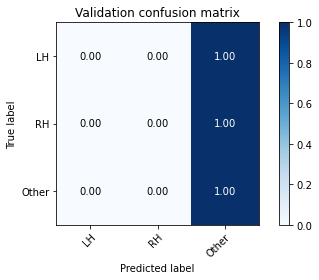

Epoch 1
Train  Loss: 0.94370
Train  Accuracy: 48.6%
Valid  Loss: 0.99707
Valid  Accuracy: 51.9%
model saved
[[ 20   0 239]
 [  0   2 254]
 [  4   1 516]]
Normalized confusion matrix


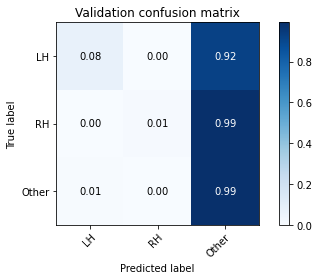

Epoch 2
Train  Loss: 0.85211
Train  Accuracy: 52.7%
Valid  Loss: 1.01601
Valid  Accuracy: 49.1%
Epoch 3
Train  Loss: 0.84885
Train  Accuracy: 52.6%
Valid  Loss: 0.96667
Valid  Accuracy: 53.7%
model saved
[[ 60   0 199]
 [  7   9 240]
 [ 26   8 487]]
Normalized confusion matrix


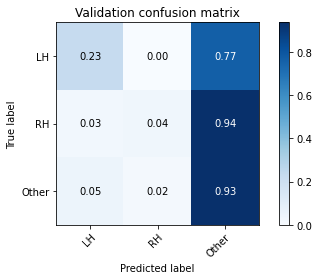

Epoch 4
Train  Loss: 0.84132
Train  Accuracy: 52.4%
Valid  Loss: 0.97637
Valid  Accuracy: 52.5%
Epoch 5
Train  Loss: 0.83800
Train  Accuracy: 54.5%
Valid  Loss: 0.96728
Valid  Accuracy: 53.0%
Epoch 6
Train  Loss: 0.81451
Train  Accuracy: 55.2%
Valid  Loss: 0.95861
Valid  Accuracy: 55.0%
model saved
[[ 76   9 174]
 [ 21  73 162]
 [ 52  48 421]]
Normalized confusion matrix


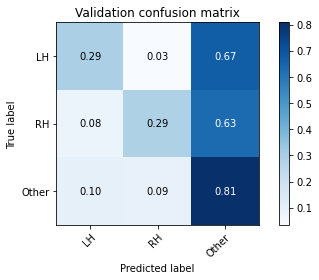

Epoch 7
Train  Loss: 0.81303
Train  Accuracy: 54.9%
Valid  Loss: 0.95107
Valid  Accuracy: 54.4%
Epoch 8
Train  Loss: 0.79982
Train  Accuracy: 55.9%
Valid  Loss: 0.93936
Valid  Accuracy: 57.2%
model saved
[[ 74   7 178]
 [ 20  68 168]
 [ 39  31 451]]
Normalized confusion matrix


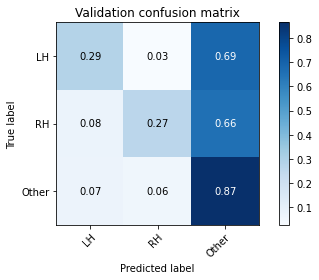

Epoch 9
Train  Loss: 0.80019
Train  Accuracy: 55.6%
Valid  Loss: 0.95531
Valid  Accuracy: 56.2%
Epoch 10
Train  Loss: 0.81232
Train  Accuracy: 54.6%
Valid  Loss: 0.95521
Valid  Accuracy: 55.7%
Epoch 11
Train  Loss: 0.79775
Train  Accuracy: 55.7%
Valid  Loss: 0.95461
Valid  Accuracy: 55.1%
Epoch 12
Train  Loss: 0.84581
Train  Accuracy: 53.5%
Valid  Loss: 0.96782
Valid  Accuracy: 52.2%
Epoch 13
Train  Loss: 0.79643
Train  Accuracy: 56.0%
Valid  Loss: 0.93933
Valid  Accuracy: 55.8%
Epoch 14
Train  Loss: 0.84433
Train  Accuracy: 53.5%
Valid  Loss: 0.93315
Valid  Accuracy: 56.3%
Epoch 15
Train  Loss: 0.79304
Train  Accuracy: 56.6%
Valid  Loss: 0.94229
Valid  Accuracy: 55.1%
Epoch 16
Train  Loss: 0.77730
Train  Accuracy: 56.4%
Valid  Loss: 0.93404
Valid  Accuracy: 57.5%
model saved
[[ 49   2 208]
 [  5  66 185]
 [ 18  22 481]]
Normalized confusion matrix


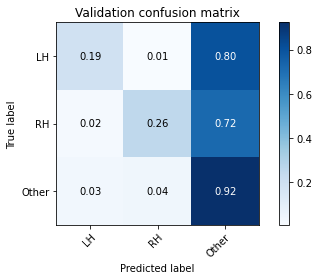

Epoch 17
Train  Loss: 0.79145
Train  Accuracy: 57.1%
Valid  Loss: 0.91303
Valid  Accuracy: 57.3%
Epoch 18
Train  Loss: 0.77306
Train  Accuracy: 56.3%
Valid  Loss: 0.92418
Valid  Accuracy: 57.1%
Epoch 19
Train  Loss: 0.74503
Train  Accuracy: 58.4%
Valid  Loss: 0.90137
Valid  Accuracy: 58.1%
model saved
[[ 76   4 179]
 [ 17  58 181]
 [ 41  12 468]]
Normalized confusion matrix


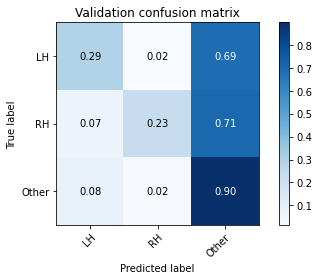

Epoch 20
Train  Loss: 0.76258
Train  Accuracy: 58.1%
Valid  Loss: 0.90733
Valid  Accuracy: 56.9%
Epoch 21
Train  Loss: 0.76722
Train  Accuracy: 57.8%
Valid  Loss: 0.90516
Valid  Accuracy: 56.6%
Epoch 22
Train  Loss: 0.73293
Train  Accuracy: 59.3%
Valid  Loss: 0.88944
Valid  Accuracy: 58.4%
model saved
[[ 84   8 167]
 [ 18  71 167]
 [ 48  23 450]]
Normalized confusion matrix


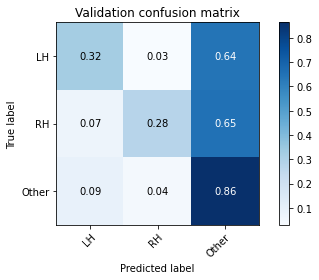

Epoch 23
Train  Loss: 0.78525
Train  Accuracy: 57.2%
Valid  Loss: 0.90517
Valid  Accuracy: 57.6%
Epoch 24
Train  Loss: 0.71826
Train  Accuracy: 61.0%
Valid  Loss: 0.89264
Valid  Accuracy: 59.9%
model saved
[[105  12 142]
 [ 27  93 136]
 [ 62  36 423]]
Normalized confusion matrix


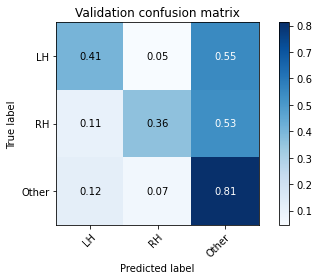

Epoch 25
Train  Loss: 0.71237
Train  Accuracy: 60.9%
Valid  Loss: 0.87199
Valid  Accuracy: 59.6%
Epoch 26
Train  Loss: 0.70942
Train  Accuracy: 61.1%
Valid  Loss: 0.86571
Valid  Accuracy: 60.8%
model saved
[[ 99  14 146]
 [ 15 104 137]
 [ 55  39 427]]
Normalized confusion matrix


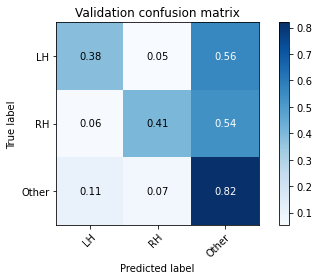

Epoch 27
Train  Loss: 0.69332
Train  Accuracy: 62.1%
Valid  Loss: 0.85163
Valid  Accuracy: 62.0%
model saved
[[122  12 125]
 [ 24 115 117]
 [ 71  45 405]]
Normalized confusion matrix


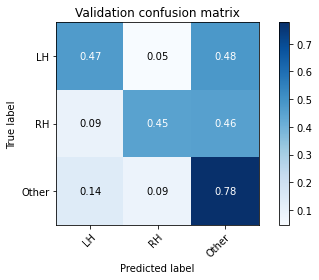

Epoch 28
Train  Loss: 0.70335
Train  Accuracy: 61.9%
Valid  Loss: 0.85852
Valid  Accuracy: 61.5%
Epoch 29
Train  Loss: 0.68172
Train  Accuracy: 63.0%
Valid  Loss: 0.84816
Valid  Accuracy: 61.2%
Epoch 30
Train  Loss: 0.66476
Train  Accuracy: 63.2%
Valid  Loss: 0.86531
Valid  Accuracy: 61.5%
Epoch 31
Train  Loss: 0.69042
Train  Accuracy: 63.0%
Valid  Loss: 0.87478
Valid  Accuracy: 59.1%
Epoch 32
Train  Loss: 0.65190
Train  Accuracy: 64.1%
Valid  Loss: 0.85079
Valid  Accuracy: 60.5%
Epoch 33
Train  Loss: 0.65958
Train  Accuracy: 63.5%
Valid  Loss: 0.91067
Valid  Accuracy: 60.5%
Epoch 34
Train  Loss: 0.64916
Train  Accuracy: 64.4%
Valid  Loss: 0.86573
Valid  Accuracy: 61.1%
Epoch 35
Train  Loss: 0.65029
Train  Accuracy: 64.5%
Valid  Loss: 0.86102
Valid  Accuracy: 61.3%
Epoch    36: reducing learning rate of group 0 to 5.0000e-04.
Epoch 36
Train  Loss: 0.61268
Train  Accuracy: 66.5%
Valid  Loss: 0.88361
Valid  Accuracy: 61.4%
Epoch 37
Train  Loss: 0.59044
Train  Accuracy: 67.9%
Valid  Loss:

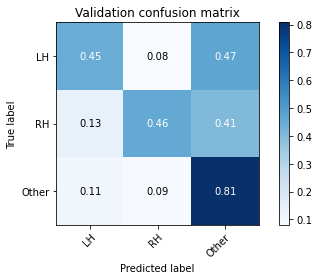

Epoch 40
Train  Loss: 0.57066
Train  Accuracy: 68.9%
Valid  Loss: 0.86326
Valid  Accuracy: 62.2%
Epoch 41
Train  Loss: 0.54603
Train  Accuracy: 69.8%
Valid  Loss: 0.88753
Valid  Accuracy: 61.1%
Epoch    42: reducing learning rate of group 0 to 2.5000e-04.
Epoch 42
Train  Loss: 0.52610
Train  Accuracy: 70.6%
Valid  Loss: 0.87738
Valid  Accuracy: 61.6%
Epoch 43
Train  Loss: 0.52122
Train  Accuracy: 71.0%
Valid  Loss: 0.88279
Valid  Accuracy: 62.5%
Epoch 44
Train  Loss: 0.52145
Train  Accuracy: 72.1%
Valid  Loss: 0.88832
Valid  Accuracy: 61.6%
Epoch 45
Train  Loss: 0.51643
Train  Accuracy: 71.9%
Valid  Loss: 0.88922
Valid  Accuracy: 60.4%
Epoch 46
Train  Loss: 0.50170
Train  Accuracy: 72.3%
Valid  Loss: 0.90024
Valid  Accuracy: 62.1%
Epoch 47
Train  Loss: 0.50179
Train  Accuracy: 73.0%
Valid  Loss: 0.90975
Valid  Accuracy: 61.4%
Epoch    48: reducing learning rate of group 0 to 1.2500e-04.
Epoch 48
Train  Loss: 0.48096
Train  Accuracy: 73.8%
Valid  Loss: 0.91209
Valid  Accuracy: 61.0%
Epo

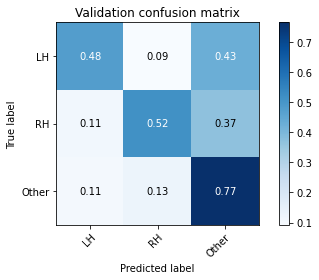

Epoch 58
Train  Loss: 0.44476
Train  Accuracy: 75.7%
Valid  Loss: 0.95602
Valid  Accuracy: 61.8%
Epoch 59
Train  Loss: 0.44512
Train  Accuracy: 75.9%
Valid  Loss: 0.95211
Valid  Accuracy: 61.9%
Epoch    60: reducing learning rate of group 0 to 3.1250e-05.
Epoch 60
Train  Loss: 0.44028
Train  Accuracy: 76.1%
Valid  Loss: 0.95435
Valid  Accuracy: 61.2%
Epoch 61
Train  Loss: 0.43716
Train  Accuracy: 76.1%
Valid  Loss: 0.95799
Valid  Accuracy: 61.4%
Epoch 62
Train  Loss: 0.43787
Train  Accuracy: 76.2%
Valid  Loss: 0.94920
Valid  Accuracy: 62.4%
Epoch 63
Train  Loss: 0.43678
Train  Accuracy: 76.3%
Valid  Loss: 0.95375
Valid  Accuracy: 60.7%
Epoch 64
Train  Loss: 0.43235
Train  Accuracy: 76.5%
Valid  Loss: 0.97184
Valid  Accuracy: 60.8%
Epoch 65
Train  Loss: 0.43444
Train  Accuracy: 76.5%
Valid  Loss: 0.95812
Valid  Accuracy: 62.2%
Epoch    66: reducing learning rate of group 0 to 1.5625e-05.
Epoch 66
Train  Loss: 0.43500
Train  Accuracy: 76.3%
Valid  Loss: 0.96066
Valid  Accuracy: 61.2%
Epo

In [14]:
batch_size = 30

total_epoch = -1
Tlosses, Taccuracies = [], []
Vlosses, Vaccuracies = [], []
highest_acc = 0

savename = "Model/cnn_model_mi.pth"

start=time.time()
for i_epoch in range(100):
    total_epoch += 1
    # Randomize batches ids and get iterater 'i_trials_in_batch'
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                             batch_size=batch_size)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X for training
        batch_X = train_set.X[i_trials][:, :, :, None]
        batch_y = train_set.y[i_trials]
        # convert from nparray to torch tensor
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()
    # Set model to evaluation mode
    model.eval()
    print("Epoch {:d}".format(total_epoch))
    average_acc = []
    average_loss = []
    
    # Here we compute training accuracy and validation accuracy of current model
    for setname, dataset in (('Train', train_set), ('Valid', valid_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                                 batch_size=batch_size)
        outputs=None
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:, :, :, None]
            batch_y = dataset.y[i_trials]
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            toutputs = model(net_in)
            if outputs is None:
                temp = toutputs.cpu()
                outputs = temp.detach().numpy()
            else:
                temp = toutputs.cpu()
                outputs = np.concatenate((outputs,temp.detach().numpy()))
        net_target = np_to_var(dataset.y)
        loss = F.nll_loss(torch.from_numpy(outputs), net_target)
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        predicted_labels = np.argmax((outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        
        print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
        if setname == 'Train':
            Tlosses.append(loss)
            Taccuracies.append(accuracy)
            current_Tacc=accuracy
        elif setname == 'Valid':
            Vlosses.append(loss)
            Vaccuracies.append(accuracy)
            scheduler.step(loss)
            if accuracy>=highest_acc:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, savename)

                highest_acc=accuracy
                print('model saved')
                plot_confusion_matrix(dataset.y, predicted_labels, 
                                      classes=['LH', 'RH', 'Other'], normalize=True,
                                      title='Validation confusion matrix')
                plt.show()
        else:
            average_acc.append(accuracy)
            average_loss.append(accuracy)
end = time.time()

print('time is {} min'.format(int((end-start)/60)))

Shallow_net-> 100 epoches, batch_size = 100, train_acc = 58.3% and valid_acc = 61.8% and test_acc = 59.3%

Motor_net2-> 100 epoches, batch_size = 100, train_acc = 74.1% and valid_acc = 66.1% and test_acc = 64.1%

Motor_net3-> 100 epoches, batch_size = 50, train_acc = 66.7% and valid_acc = 64.7% and test_acc =62.6 %

Motor_net3_new-> 100 epoches, batch_size = 30, train_acc = 72.7% and valid_acc = 66.1% and test_acc =66.6 %

Motor_net4-> 78 epoches, batch_size = 20, train_acc = 68.0% and valid_acc = 57.0% and test_acc =55.1 %

Motor_net7-> 100 epoches, batch_size = 30, train_acc = 49.8% and valid_acc = 51.2% and test_acc = 46.1 %

Motor_net8-> 100 epoches, batch_size = 30, train_acc = 78.8 % and valid_acc = 67.5 % and test_acc = 69.8 %

Motor_net9-> 100 epoches, batch_size = 30, train_acc = 81.5 % and valid_acc = 68.2 % and test_acc = 68.9 %

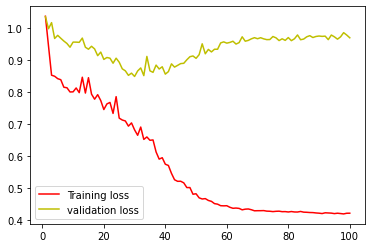

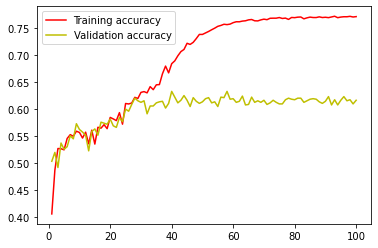

In [15]:
t = np.arange(0.0, len(Tlosses), 1)+1
plt.plot(t, Tlosses, 'r', t, Vlosses, 'y')
plt.legend(('Training loss', 'validation loss'))
plt.show()

plt.plot(t, Taccuracies, 'r', t, Vaccuracies, 'y')
plt.legend(('Training accuracy', 'Validation accuracy'))
plt.show()

testset Loss: 0.94862
testset Accuracy: 66.9%
[[103  36 119]
 [  5 115 141]
 [ 16  26 475]]
Normalized confusion matrix


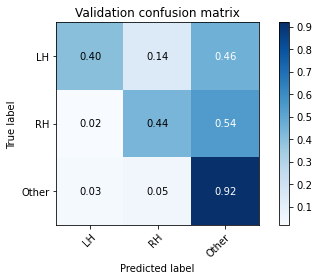

In [16]:
model = DpEEG_net()
savename = "Model/cnn_model_mi.pth"
if cuda:
    model.cuda()
    
checkpoint = torch.load(savename)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

average_acc, average_loss = [], []
setname = 'testset'
dataset = test_set

i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, shuffle=False,
                                         batch_size=30)
outputs=None
for i_trials in i_trials_in_batch:
    # Have to add empty fourth dimension to X
    batch_X = dataset.X[i_trials][:, :, :, None]
    batch_y = dataset.y[i_trials]
    net_in = np_to_var(batch_X)
    if cuda:
        net_in = net_in.cuda()
    toutputs = model(net_in)
    if outputs is None:
        temp = toutputs.cpu()
        outputs = temp.detach().numpy()
    else:
        temp = toutputs.cpu()
        outputs = np.concatenate((outputs,temp.detach().numpy()))

net_target = np_to_var(dataset.y)
loss = F.nll_loss(torch.from_numpy(outputs), net_target)
print("{:6s} Loss: {:.5f}".format(setname, float(var_to_np(loss))))
predicted_labels = np.argmax((outputs), axis=1)
accuracy = np.mean(dataset.y  == predicted_labels)

print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
plot_confusion_matrix(dataset.y, predicted_labels, 
                      classes=['LH','RH','Other'], normalize=True,
                      title='Validation confusion matrix')
plt.show()